In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

import os

from ms_stim_analysis.Analysis.utils import filter_opto_data, smooth
from ms_stim_analysis.AnalysisTables.ms_opto_stim_protocol import OptoStimProtocol
from ms_stim_analysis.AnalysisTables.decoding_tables import (
    ContinuousRippleTraversal,
    ContinuousRippleTraversalSelection,
    ContinuousRippleTraversalParams,
)
os.curdir
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1

[2025-08-28 09:52:29,013][INFO]: DataJoint 0.14.6 connected to sambray@lmf-db.cin.ucsf.edu:3306


In [ ]:
# # # Logging for database export. Not necessary for replication

# from spyglass.common.common_usage import Export, ExportSelection

# paper_key = {"paper_id": "ms_stim_analysis"}

# analysis_id = "continuous_traversals_epoch1"
# # (ExportSelection() & {**paper_key, "analysis_id": analysis_id}).delete()

# ExportSelection().start_export(**paper_key, analysis_id=analysis_id)

[09:01:18][INFO] Spyglass: Export 46 in progress. Starting new.
[09:01:18][INFO] Spyglass: Resuming {'export_id': 46}


# Plotting exemplar long traces


In [7]:
query_key = dict(nwb_file_name="Totoro20220613_.nwb", pos_interval="pos 1 valid times")
query = ContinuousRippleTraversal() & query_key

longest_key = None
max_length = 0

for key in query.fetch("KEY"):
    df = (query & key).fetch1_dataframe()
    if df.longest_traversal.max() > max_length:
        max_length = df.longest_traversal.max()
        longest_key = key

query & longest_key
traversal_df = (query & longest_key).fetch1_dataframe()

/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.2.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please c

In [8]:
Decoder = ClusterlessDecodingV1
# Decoder = SortedSpikesDecodingV1

nwb_file_name = longest_key["nwb_file_name"]
interval = longest_key["position_group_name"].strip("DLC ")
encoding_tag = ""  # "_opto_control_interval"
causal_tag = ""  # "_causal"
key = {
    "nwb_file_name": nwb_file_name,
    "position_group_name": "DLC " + interval,
    "encoding_interval": interval + encoding_tag,
}
key = (
    (Decoder() & key)
    & f"decoding_param_name LIKE '%{causal_tag}'"
    # & "sorted_spikes_group_name NOT LIKE 'manual%'"
).fetch1("KEY")

pos_df = Decoder().fetch_linear_position_info(key)
results = (Decoder() & key).fetch_results()
posterior = results.acausal_posterior.unstack("state_bins").sum("state")[0]
decode_pos = posterior.idxmax("position").values

opto_key = {
    "nwb_file_name": nwb_file_name,
    "interval_list_name": interval,
}
stim, stim_time = OptoStimProtocol().get_stimulus(opto_key)

linear_pos = pos_df["linear_position"].values

if "sorted" in Decoder.full_table_name:
    spikes = Decoder().fetch_spike_data(key)
else:
    spikes = Decoder().fetch_spike_data(key)[0]
flat_spikes = np.concatenate(spikes)
spike_inds = np.digitize(flat_spikes, pos_df.index.values)
mua = np.bincount(spike_inds, minlength=len(pos_df))
mua = smooth(mua, 5)
mua = mua / np.mean(np.diff(pos_df.index.values))
environment = Decoder().fetch_environments(key)[0]
distance_dict = environment.distance_between_nodes_

/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/spyglass/decoding/v1/core.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or 

In [ ]:
from spyglass.lfp.analysis.v1.lfp_band import LFPBandV1
from spyglass.lfp.v1 import LFPV1
from spyglass.lfp.lfp_merge import LFPOutput
from spyglass.ripple.v1 import RippleTimesV1, RippleLFPSelection

LFPV1 & {"nwb_file_name": nwb_file_name, "target_interval_list_name": interval}
artifact_detection = "ms_lfp_artifact_times"
band_query = (
    LFPBandV1()
    & {
        "nwb_file_name": nwb_file_name,
        #    "target_interval_list_name": interval,
        "filter_name": "Ripple 150-250 Hz",
    }
    & "target_interval_list_name LIKE '%{}%'".format(interval)
    & f"target_interval_list_name LIKE '%{artifact_detection}%'"
)

band_query
ripple_band_df = band_query.fetch1_dataframe()
state_posterior = results.acausal_posterior.unstack("state_bins").sum("position")[0]
state_posterior.shape

/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.2.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [11]:
longest_key
test_intervals = (
    OptoStimProtocol
    & longest_key
    & {"interval_list_name": longest_key["decoding_interval"]}
).fetch1("test_intervals")

first_test_interval = np.array([test_intervals[0]])

from spyglass.common import interval_list_contains_ind

ind_ripples = interval_list_contains_ind(
    first_test_interval, traversal_df["start_time"].values
)
traversal_df = traversal_df.iloc[ind_ripples]

[09:09:04][WARNING] Spyglass: DEPRECATION scheduled for Spyglass 0.6.0: interval_list_contains_ind
	Use Interval.contains instead


In [12]:
ripple_num = np.argsort(traversal_df.longest_traversal.values)
print(ripple_num)
# Winnie
# ripple_num = ripple_num[-3]
# ripple_num = ripple_num[-2]
# ripple_num = ripple_num[-5]
# Wallie
# ripple_num = ripple_num[-3]
# ripple_num = 294
# Yoshi
# ripple_num = ripple_num[-1]
# ripple_num = ripple_num[-2]
# ripple_num = ripple_num[-3]


ripple_num = ripple_num[-2]
# print(traversal_df.iloc[ripple_num])
st = traversal_df.iloc[ripple_num].start_time
en = traversal_df.iloc[ripple_num].end_time
# traversal_df.iloc[ripple_num]
# longest_key

[  0   1   2  11 105 106  95  96  98  87  90  21  22  24  78  79  80  73
  63  64  65  66  27  28  33  52  43  49  35  37   3   4   5 107 108 110
 111 112 114  18  41  44  42  45  46  48  47 101  94  93  56  55  54  53
  51  62  32  59  67  58  57  31  88  19  20  74  72  71  70  69  68  17
  12  13  14  38  36  39  40  15  86  23  26  10   9   8  89   6  91  16
  77  97  92  34  30  82  84  60  61 104 100 113  83  76  99  29  85 102
  50  25  81   7  75 109 103]


[206036 206037 206038 206039 206040 206041 206042 206043 206044 206045
 206046 206047 206048 206049 206050 206051 206052 206053 206054 206055
 206056 206057 206058 206059 206060 206061 206062 206063 206064 206065
 206066 206067 206068 206069 206070 206071 206072 206073 206074 206075
 206076 206077 206078 206079 206080 206081 206082 206083 206084 206085
 206086 206087 206088 206089 206090 206091 206092 206093 206094 206095
 206096 206097 206098 206099 206100 206101 206102 206103 206104 206105
 206106 206107 206108 206109 206110 206111 206112 206113 206114 206115
 206116 206117 206118 206119 206120 206121 206122 206123 206124 206125
 206126 206127 206128 206129 206130 206131 206132 206133 206134 206135
 206136 206137 206138 206139 206140 206141 206142 206143 206144 206145
 206146 206147 206148 206149 206150 206151 206152 206153 206154 206155
 206156 206157 206158 206159 206160 206161 206162 206163 206164 206165
 206166 206167 206168 206169 206170 206171 206172 206173 206174 206175
 20617

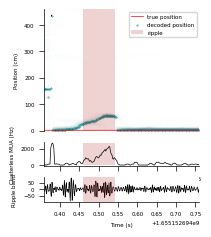

In [14]:
# pos_df
posterior.shape, pos_df.shape

# t0 = pos_df.index.values[0] - 9 * 60 + 30.4
t0 = 0

t_rng = (st - 0.1, st + 0.3)
# t_rng = (st - 0.1, st + 0.5)

plt.rcParams.update({"font.size": 4})
lw = 0.5
plt.rcParams.update({"lines.linewidth": lw})
plt.rcParams.update({"axes.linewidth": lw})
plt.rcParams["xtick.major.width"] = lw  # Width of major x-ticks
plt.rcParams["ytick.major.width"] = lw
fig, ax = plt.subplots(
    nrows=3,
    figsize=(2, 2.5),
    # figsize=(6, 7.5),
    sharex=False,
    height_ratios=[20, 4, 4],
)
# ax = [ax]
ind = np.where(
    (pos_df.index.values >= t0 + t_rng[0]) & (pos_df.index.values < t0 + t_rng[1])
)[0]

ind

print(ind)
# ax[0].imshow(
#     posterior[ind].T,
#     aspect=0.0005,
#     extent=[*t_rng, results.position.max() + results.position.min() + 0, 0],
#     cmap="bone_r",
#     clim=[0, 0.05],
#     zorder=-1,
# )
t_plot = pos_df.index[ind].values  # - t0
xx, yy = np.meshgrid(t_plot, results.position)
pos_val = results.position.values
pos_val = pos_val[: pos_val.shape[0] // 2]
XX, YY = np.meshgrid(t_plot, pos_val)
clim = None
ax[0].pcolormesh(
    XX,
    YY,
    posterior[ind].T,
    cmap="bone_r",
    shading="nearest",
    clim=clim,
    rasterized=True,
)
# ax[0].scatter(t_plot, linear_pos[ind], color="r", s=.15)

ax[0].plot(t_plot, linear_pos[ind], "r", label="true position")
ax[0].scatter(t_plot, decode_pos[ind], color="teal", s=0.1, label="decoded position")


ax[1].plot(t_plot, mua[ind], "k")

# ripples
ind_ripple = np.where(
    np.logical_and(
        (ripple_band_df.index.values >= t0 + t_rng[0]),
        (ripple_band_df.index.values < t0 + t_rng[1]),
    )
)[0]
t_rip = ripple_band_df.index[ind_ripple]
y_rip = ripple_band_df.iloc[ind_ripple].values[:, 2].astype(float)
gaps = np.where(np.diff(t_rip) > 0.01)[0] + 1
y_rip[gaps] = 1.0 * np.nan
ax[2].plot(t_rip, y_rip, "k")
ax[2].set_ylabel("Ripple band")
rip_lo = np.nanmin(y_rip) * 1.05
rip_hi = np.nanmax(y_rip) * 1.05
ax[2].fill_between(
    [st, en], rip_lo, rip_hi, facecolor="firebrick", alpha=0.2, zorder=10
)
ax[2].set_ylim(rip_lo, rip_hi)


ax[0].fill_between(
    [st, en],
    0,
    np.nanmax(linear_pos),
    facecolor="firebrick",
    alpha=0.2,
    zorder=10,
    label="ripple",
)
ax[1].fill_between(
    [st, en], 0, np.nanmax(mua[ind]), facecolor="firebrick", alpha=0.2, zorder=0
)

ax[-1].set_xlabel("Time (s)")
ax[0].set_ylabel("Position (cm)")
ax[1].set_ylabel("Clusterless MUA (Hz)")
ax[0].legend()

for a in ax:
    a.spines[["top", "right"]].set_visible(False)
    a.set_xlim(t_rng)
ax[0].spines[["bottom"]].set_visible(False)
ax[0].set_xticks([])


plt.rcParams["svg.fonttype"] = "none"
fig.savefig(
    f"../Figures/Fig_5/Fig_5a_wtrack_first_epoch_{nwb_file_name}_{interval}_ripple_{ripple_num}.svg"
)